# 시계열 분해

In [2]:
#!skip_error
import pandas as pd
df = pd.read_excel('elecequip.xlsx')
ym = pd.melt(df, id_vars=['year'], 
             var_name='month', 
             value_name='demand')
ym

,year,month,demand
0,1996,Jan,79.35
1,1997,Jan,78.64
2,1998,Jan,81.87
3,1999,Jan,81.59
4,2000,Jan,95.30
...,...,...,...
199,2008,Dec,101.18
200,2009,Dec,102.52
201,2010,Dec,103.48
202,2011,Dec,98.34


In [3]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ym['month'] = pd.Categorical(
    ym['month'], categories=months, ordered=True)
ym = ym.sort_values(['year', 'month']).dropna().reset_index()
ym

,index,year,month,demand
0,0,1996,Jan,79.35
1,17,1996,Feb,75.78
2,34,1996,Mar,86.32
3,51,1996,Apr,72.60
4,68,1996,May,74.86
...,...,...,...,...
190,185,2011,Nov,93.37
191,202,2011,Dec,98.34
192,16,2012,Jan,86.44
193,33,2012,Feb,85.04


## 이동 평균

<Axes: >

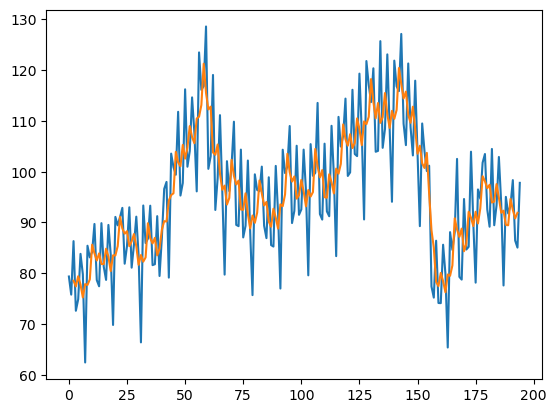

In [4]:
ma4 = ym.demand.rolling(4, center=True).mean()

ym.demand.plot()
ma4.plot()

<Axes: >

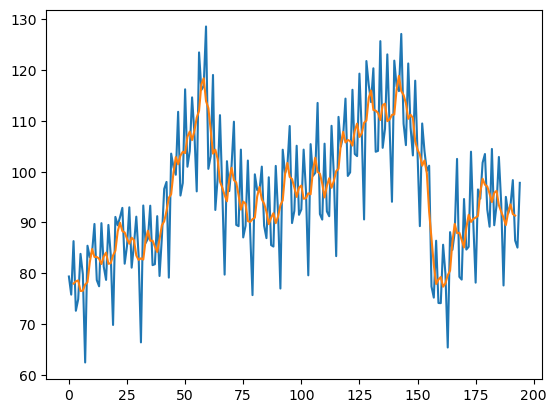

In [5]:
# 이동평균의 이동평균 or 중심화된 이동평균
ma2x4 = ma4.rolling(2).mean().shift(-1)
ym.demand.plot()
ma2x4.plot()

## 고전적 분해법

추세(이동평균) + 계절성(계절별 평균) + 나머지

In [8]:
#!skip_error

import numpy as np

y2 = ym.demand - ma2x4 # 추세 제거
monthly = y2.groupby(ym.month).mean() # 계절 성분

total = len(ym)
year = int(np.ceil(total / len(monthly))) # int 추가
seasonal = np.tile(monthly, year)[:total]

remainder = y2 - seasonal # 나머지 성분

C:\Users\eupho\AppData\Local\Temp\ipykernel_43488\3631648127.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = y2.groupby(ym.month).mean() # 계절 성분


### seasonal_decompose

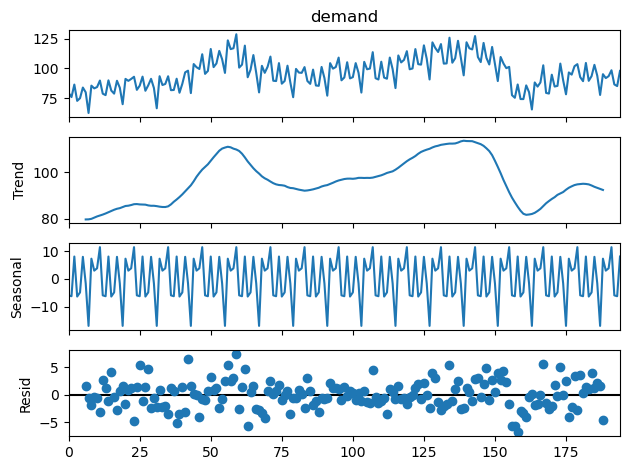

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ym['demand'], model='additive', period=12)
result.plot();

손으로 계산한 결과와 비슷하게 2x4 이동평균을 적용하려면 다음과 같이 `filt`를 설정

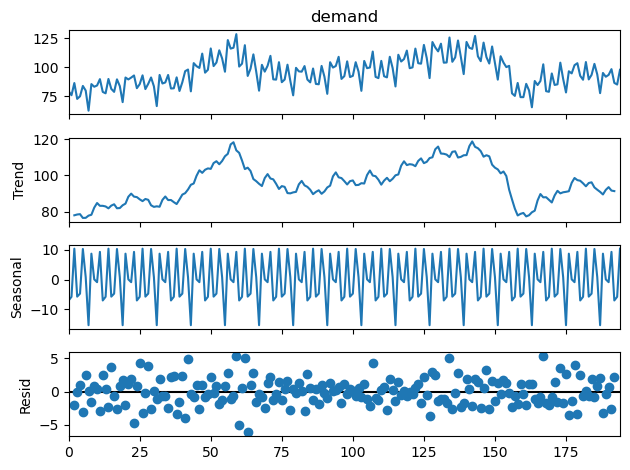

In [35]:
result = seasonal_decompose(ym['demand'], model='additive', filt=[.5/4, 1/4, 1/4, 1/4, .5/4], period=12)
result.plot();

## STL 분해

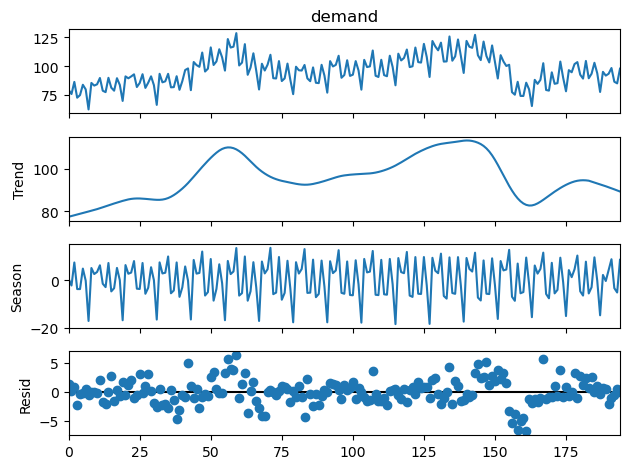

In [9]:
from statsmodels.tsa.seasonal import STL
m = STL(ym.demand, period=12).fit()
m.plot();

## 추세와 계절성의 강도

R제곱의 논리와 비슷한 방법으로 추세가 얼마나 많은 부분을 설명하는지 표현할 수 있음

추세의 강도

In [10]:
1 - m.resid.var() / (m.trend + m.resid).var()

0.9564002838163896

계절성의 강도

In [11]:
1 - m.resid.var() / (m.seasonal + m.resid).var()

0.9307784372113894